## Imports

In [1]:
%pip install xgboost arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 11.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from typing import Dict, List, Tuple
from tqdm.notebook import tqdm
import random

## Data preparation functions

We engineer a bunch of features related to sentiment, so the fact that the model *still* doesn't perform better when trained on sentiment data damns the hypothesis that Reddit discussions are predictive of price.

Since we don't have sentiment data for every date, we add a column specifying whether a feature is available or not (rather than filling neutral value for those dates, or something). The hope is that the model learns what this feature means.

We train two models: one *only* on pricing data, and one on both pricing and sentiment data. We find that the two models have identical performance to 4 decimal places.

In [3]:
def identify_continuous_chunks(df, max_gap_days=5):
    """
    Split DataFrame into continuous chunks where gaps don't exceed max_gap_days.
    Returns list of DataFrames.
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['days_between'] = df['Date'].diff().dt.days

    # Find break points where gaps exceed max_gap_days
    break_points = df[df['days_between'] > max_gap_days].index.tolist()

    # Split into chunks
    chunks = []
    start_idx = 0

    for end_idx in break_points:
        chunk = df.iloc[start_idx:end_idx].copy()
        if len(chunk) > 30:  # Only keep chunks with enough data
            chunks.append(chunk)
        start_idx = end_idx

    # Add the last chunk
    final_chunk = df.iloc[start_idx:].copy()
    if len(final_chunk) > 30:
        chunks.append(final_chunk)

    print(f"Split data into {len(chunks)} continuous chunks:")
    for i, chunk in enumerate(chunks):
        print(f"Chunk {i}: {chunk['Date'].min()} to {chunk['Date'].max()}, {len(chunk)} records")

    return chunks

def calculate_forward_volatility(returns, window=7):
    """
    Calculate true forward-looking volatility
    Returns the volatility of the NEXT window days
    """
    # -window shifts the data BACKWARD
    return returns.shift(-window).rolling(window).std()

def calculate_historical_volatility(returns, window=7):
    """
    Calculate historical volatility using strictly past data
    Returns the volatility of the PAST window days
    """
    return returns.rolling(window).std()

def prepare_features(df, target_window=14, feature_window=14):
    """
    Prepare features using strictly past data
    """
    feature_df = pd.DataFrame(index=df.index)

    # Calculate forward volatility first (our target)
    for asset in ['Bitcoin', 'BNB', 'Doge', 'Ethereum']:
        returns_col = f'{asset}_Return'
        # Target: Volatility of the NEXT 7 days
        feature_df[f'{asset}_ForwardVol'] = calculate_forward_volatility(df[returns_col], window=7)

        # Feature: Volatility of the PAST 7 days
        feature_df[f'{asset}_HistoricalVol'] = calculate_historical_volatility(df[returns_col], window=7)
        feature_df[f'{asset}_AbsReturn'] = np.abs(df[returns_col])
        feature_df[f'{asset}_HistoricalMeanReturn'] = df[returns_col].rolling(feature_window, min_periods=feature_window).mean()
        feature_df[f'{asset}_HistoricalMaxReturn'] = df[returns_col].rolling(feature_window, min_periods=feature_window).max()
        feature_df[f'{asset}_HistoricalMinReturn'] = df[returns_col].rolling(feature_window, min_periods=feature_window).min()

        # Volume features
        vol_col = f'{asset}_Vol'
        feature_df[f'{asset}_HistoricalVolumeAvg'] = df[vol_col].rolling(feature_window, min_periods=feature_window).mean()
        feature_df[f'{asset}_HistoricalVolumeSt'] = df[vol_col].rolling(feature_window, min_periods=feature_window).std()

    # Add sentiment features
    sentiment_features = [
        'weighted_conviction', 'weighted_sentiment',
        'normalized_weighted_conviction', 'normalized_weighted_sentiment',
        'conviction_avg', 'conviction_std',
        'weighted_conviction_avg', 'weighted_conviction_std',
        'weighted_sentiment_avg', 'weighted_sentiment_std'
    ]

    # Engineer and add an availability feature for XGBoost
    for feat in sentiment_features:
        if feat in df.columns:
            feature_df[feat] = df[feat]
            feature_df[f'{feat}_available'] = (~df[feat].isna()).astype(int)
            feature_df[feat] = df[feat].fillna(0)

    # Drop rows where we don't have enough history or future data for target
    feature_df = feature_df.dropna()

    # Drop last 'target_window' rows as we don't have future data to calculate target
    feature_df = feature_df.iloc[:-target_window]

    return feature_df

## XGBoost training function

64% train + 18% val + 20% test

In [4]:
def train_and_evaluate_chunk(xgb_config, chunk_df, target_asset='Bitcoin', test_size=0.2, val_size=0.2):
    """Train and evaluate models on a single continuous chunk of data with validation split"""
    window = 5
    feature_df = prepare_features(chunk_df, target_window=window, feature_window=window)
    if feature_df is None or len(feature_df) < 50:  # Need minimum amount of data
        return None

    target_col = f'{target_asset}_ForwardVol'
    feature_cols = [col for col in feature_df.columns
                   if not col.endswith('_ForwardVol')]

    # Split into train+val and test
    test_split_idx = int(len(feature_df) * (1 - test_size))
    train_val_df = feature_df.iloc[:test_split_idx]
    test_df = feature_df.iloc[test_split_idx:]

    # Further split train into train and validation
    train_size = int(len(train_val_df) * (1 - val_size))
    train_df = train_val_df.iloc[:train_size]
    val_df = train_val_df.iloc[train_size:]

    if len(train_df) < 30 or len(val_df) < 10 or len(test_df) < 10:
        return None

    # Separate features for base model (no sentiment)
    base_cols = [col for col in feature_cols
                if not any(x in col.lower() for x in ['sentiment', 'conviction'])]

    # Train base model
    base_model = xgb.XGBRegressor(**xgb_config)
    base_model.fit(train_df[base_cols], train_df[target_col])

    # Train enhanced model
    enhanced_model = xgb.XGBRegressor(**xgb_config)
    enhanced_model.fit(train_df[feature_cols], train_df[target_col])

    # Final evaluation on test set
    base_pred = base_model.predict(test_df[base_cols])
    enhanced_pred = enhanced_model.predict(test_df[feature_cols])

    results = {
        'period': f"{chunk_df['Date'].min()} to {chunk_df['Date'].max()}",
        'n_samples': len(chunk_df),
        'training_samples': len(train_df),
        'test_samples': len(test_df),
        'base_rmse': np.sqrt(mean_squared_error(test_df[target_col], base_pred)),
        'enhanced_rmse': np.sqrt(mean_squared_error(test_df[target_col], enhanced_pred)),
        'base_r2': r2_score(test_df[target_col], base_pred),
        'enhanced_r2': r2_score(test_df[target_col], enhanced_pred)
    }

    naive_pred = test_df[f'{target_asset}_HistoricalVol']
    results['naive_rmse'] = np.sqrt(mean_squared_error(test_df[target_col], naive_pred))
    results['naive_r2'] = r2_score(test_df[target_col], naive_pred)

    return results, base_model, enhanced_model, test_df

## XGBoost hyperparameter tuning

In [5]:
def random_search_xgboost(chunks: List[pd.DataFrame], n_trials: int = 50, param_ranges: Dict = None) -> Dict:
    """
    Perform random search using validation set for hyperparameter optimization.
    """
    if param_ranges is None:
        param_ranges = {
            "n_estimators": (10, 500),
            "learning_rate": (0.01, 0.3),
            "max_depth": (2, 10),
            "min_child_weight": (1, 10),
            "subsample": (0.5, 1.0),
            "colsample_bytree": (0.5, 1.0)
        }

    best_rmse = float('inf')
    best_config = None

    for trial in tqdm(range(n_trials), desc="Random Search Progress"):
        config = {
            "n_estimators": random.randint(*param_ranges["n_estimators"]),
            "learning_rate": random.uniform(*param_ranges["learning_rate"]),
            "max_depth": random.randint(*param_ranges["max_depth"]),
            "min_child_weight": random.randint(*param_ranges["min_child_weight"]),
            "subsample": random.uniform(*param_ranges["subsample"]),
            "colsample_bytree": random.uniform(*param_ranges["colsample_bytree"]),
            "random_state": 42
        }

        # Evaluate on validation sets across all chunks
        val_rmses = []
        for chunk in chunks:
            window = 5
            feature_df = prepare_features(chunk, target_window=window, feature_window=window)
            if feature_df is None or len(feature_df) < 50:
                continue

            # Split into train+val and test (we'll only use train+val for tuning)
            test_size = 0.2
            val_size = 0.2
            test_split_idx = int(len(feature_df) * (1 - test_size))
            train_val_df = feature_df.iloc[:test_split_idx]

            # Split train_val into train and validation
            train_size = int(len(train_val_df) * (1 - val_size))
            train_df = train_val_df.iloc[:train_size]
            val_df = train_val_df.iloc[train_size:]

            if len(train_df) < 30 or len(val_df) < 10:
                continue

            # Train and evaluate on validation set
            target_col = 'Bitcoin_ForwardVol'
            base_cols = [col for col in train_df.columns
                        if not col.endswith('_ForwardVol') and
                        not any(x in col.lower() for x in ['sentiment', 'conviction'])]

            model = xgb.XGBRegressor(**config)
            model.fit(train_df[base_cols], train_df[target_col])
            val_pred = model.predict(val_df[base_cols])
            val_rmse = np.sqrt(mean_squared_error(val_df[target_col], val_pred))
            val_rmses.append(val_rmse)

        if val_rmses:
            avg_val_rmse = np.mean(val_rmses)
            if avg_val_rmse < best_rmse:
                best_rmse = avg_val_rmse
                best_config = config
                print(f"\nNew best configuration found!")
                print(f"Average Validation RMSE: {best_rmse:.4f}")
                print("Configuration:")
                for param, value in best_config.items():
                    print(f"{param}: {value}")

    return best_config

## Analysis of gaps in time data

Clearly, the data has jumps in between. This is bad! So we separate the data into three chunks and train *separate* XGBoost models (with the same hyperparameters) for each.

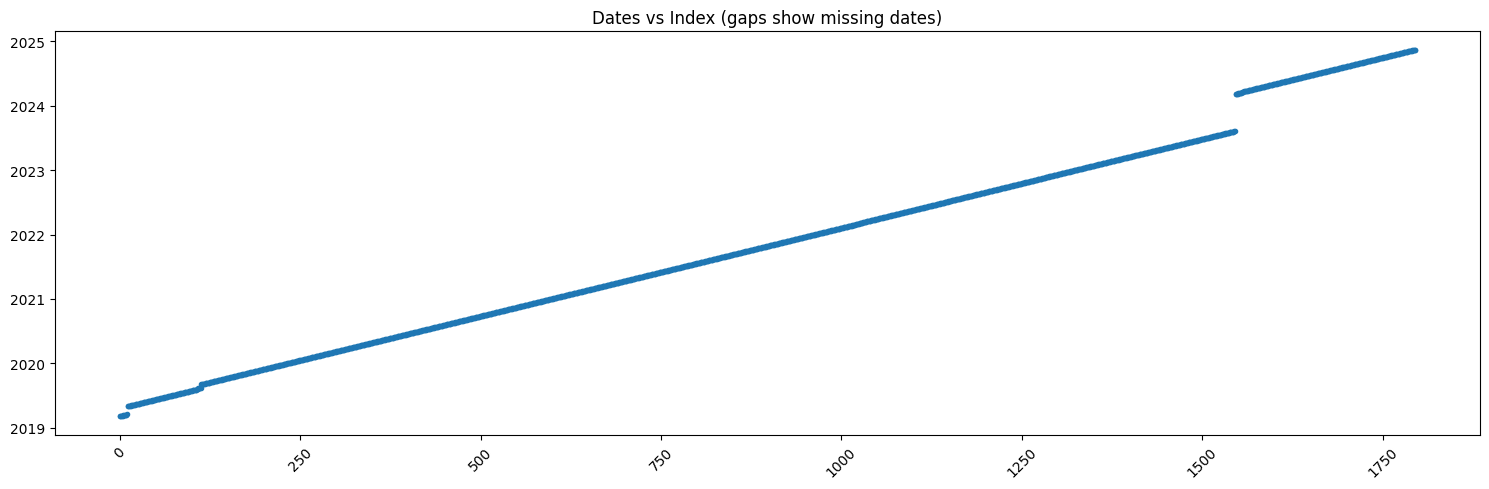


Gaps in data (intervals > 1 day):
Gap of 46.0 days before 2019-05-03
Gap of 4.0 days before 2019-08-10
Gap of 2.0 days before 2019-08-13
Gap of 19.0 days before 2019-09-04
Gap of 3.0 days before 2022-03-06
Gap of 2.0 days before 2022-07-05
Gap of 2.0 days before 2022-11-20
Gap of 210.0 days before 2024-03-07
Gap of 4.0 days before 2024-03-19


In [10]:
# Calculate days between consecutive dates
df = pd.read_csv('combined_data.csv')
df['Date'] = pd.to_datetime(df['Date'])  # ordering dates in CSV
df['days_between'] = df['Date'].diff().dt.days

# Plot dates vs index to see gaps
plt.figure(figsize=(15, 5))
plt.plot(df['Date'], '.')
plt.title('Dates vs Index (gaps show missing dates)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show any gaps larger than 1 day
gaps = df[df['days_between'] > 1]
if len(gaps) > 0:
    print("\nGaps in data (intervals > 1 day):")
    for idx, row in gaps.iterrows():
        print(f"Gap of {row['days_between']} days before {row['Date'].strftime('%Y-%m-%d')}")

## Running XGBoost

Notice that the performance of the base model is identical to the performance of the model enhanced with sentiment data. This suggests that XGBoost is learning to completely ignore sentiment data. This is to be expected: as Abdullah's data visualization points out, Reddit crypto data is overwhelmingly positive, so there's little signal there.

The naive prediction is a baseline: it's the mean of the test data historical volatility. XGBoost does beat this baseline.

In [11]:
# Load data
df = pd.read_csv('combined_data.csv')
df['Date'] = pd.to_datetime(df['Date'])  # ordering dates in CSV

# Split into continuous chunks
chunks = identify_continuous_chunks(df, max_gap_days=5)

best_config = random_search_xgboost(chunks, n_trials=50)
XGBConfig = best_config

# Train and evaluate on each chunk
all_results = []
for chunk in chunks:
    results, base_model, enhanced_model, test_df = train_and_evaluate_chunk(XGBConfig, chunk)
    if results is not None:
        all_results.append(results)
        print(f"\nPeriod: {results['period']}")
        print(f"Samples: {results['n_samples']} (Train: {results['training_samples']}, Test: {results['test_samples']})")
        print(f"Test Mean RMSE: {results['naive_rmse']:.4f}")
        print(f"Base RMSE: {results['base_rmse']:.4f}")
        print(f"Enhanced RMSE: {results['enhanced_rmse']:.4f}")
        print(f"Test Mean R²: {results['naive_r2']:.4f}")
        print(f"Base R²: {results['base_r2']:.4f}")
        print(f"Enhanced R²: {results['enhanced_r2']:.4f}")

Split data into 3 continuous chunks:
Chunk 0: 2019-05-03 00:00:00 to 2019-08-16 00:00:00, 102 records
Chunk 1: 2019-09-04 00:00:00 to 2023-08-10 00:00:00, 1433 records
Chunk 2: 2024-03-07 00:00:00 to 2024-11-14 00:00:00, 250 records


Random Search Progress:   0%|          | 0/50 [00:00<?, ?it/s]


New best configuration found!
Average Validation RMSE: 0.0148
Configuration:
n_estimators: 372
learning_rate: 0.2367255677249495
max_depth: 7
min_child_weight: 3
subsample: 0.661123440342605
colsample_bytree: 0.8982470555858705
random_state: 42

New best configuration found!
Average Validation RMSE: 0.0147
Configuration:
n_estimators: 417
learning_rate: 0.09460742861521948
max_depth: 9
min_child_weight: 1
subsample: 0.9556431030366573
colsample_bytree: 0.5178785457560915
random_state: 42

Period: 2019-05-03 00:00:00 to 2019-08-16 00:00:00
Samples: 102 (Train: 53, Test: 17)
Test Mean RMSE: 0.0279
Base RMSE: 0.0093
Enhanced RMSE: 0.0093
Test Mean R²: -2.8428
Base R²: 0.5750
Enhanced R²: 0.5750

Period: 2019-09-04 00:00:00 to 2023-08-10 00:00:00
Samples: 1433 (Train: 905, Test: 283)
Test Mean RMSE: 0.0129
Base RMSE: 0.0150
Enhanced RMSE: 0.0150
Test Mean R²: -0.3668
Base R²: -0.8413
Enhanced R²: -0.8413

Period: 2024-03-07 00:00:00 to 2024-11-14 00:00:00
Samples: 250 (Train: 148, Test: 4

## Training ARIMA

Compare against naive predictions: last known historical volatility.

In [12]:
def calculate_forward_volatility(returns, window=7):
    """
    Calculate true forward-looking volatility - the volatility of the NEXT window days
    """
    forward_returns = returns.shift(-1)  # Shift returns to avoid lookahead
    return forward_returns.rolling(window).std().shift(-window+1)

def calculate_historical_volatility(returns, window=7):
    """
    Calculate historical volatility using strictly past data
    """
    return returns.rolling(window).std()

def train_evaluate_arima_chunk(chunk_df, target_asset='Bitcoin', test_size=0.2, window=7):
    """Train and evaluate ARIMA model on a single continuous chunk of data"""

    # Create target and historical volatility
    returns_col = f'{target_asset}_Return'
    chunk_df = chunk_df.copy()

    # Calculate true forward volatility (what we want to predict)
    chunk_df['forward_vol'] = calculate_forward_volatility(chunk_df[returns_col], window)

    # Calculate historical volatility (for naive baseline)
    chunk_df['historical_vol'] = calculate_historical_volatility(chunk_df[returns_col], window)

    # Remove NaN values
    chunk_df = chunk_df.dropna(subset=['forward_vol', 'historical_vol'])

    if len(chunk_df) < 50:  # Need minimum amount of data
        return None

    # Split ensuring no lookahead bias
    train_size = int(len(chunk_df) * (1 - test_size))
    train_df = chunk_df.iloc[:train_size]
    test_df = chunk_df.iloc[train_size:]

    if len(train_df) < 30 or len(test_df) < 10:
        return None

    # Function to find best ARIMA parameters
    def find_best_arima_params(train_series):
        best_aic = float('inf')
        best_params = None

        # Grid search over parameters
        p_values = range(0, 3)
        d_values = range(0, 2)
        q_values = range(0, 3)

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        model = ARIMA(train_series, order=(p,d,q))
                        results = model.fit()
                        if results.aic < best_aic:
                            best_aic = results.aic
                            best_params = (p,d,q)
                    except:
                        continue

        # Return a reasonable set of params even if errors out for some reason
        return best_params if best_params is not None else (1,1,1)

    try:
        # Find best parameters using training data
        best_params = find_best_arima_params(train_df['historical_vol'])

        # Train model with best parameters
        # We train on historical vol but predict forward vol
        model = ARIMA(train_df['historical_vol'], order=best_params)
        arima_model = model.fit()

        # Make predictions
        # The prediction will be for the next period's volatility
        arima_pred = arima_model.forecast(steps=len(test_df))

        # Get naive predictions (using last known historical volatility)
        naive_pred = test_df['historical_vol']

        # Calculate metrics against true forward volatility
        results = {
            'period': f"{chunk_df['Date'].min()} to {chunk_df['Date'].max()}",
            'n_samples': len(chunk_df),
            'training_samples': len(train_df),
            'test_samples': len(test_df),
            'arima_params': best_params,
            'arima_rmse': np.sqrt(mean_squared_error(test_df['forward_vol'], arima_pred)),
            'arima_r2': r2_score(test_df['forward_vol'], arima_pred),
            'naive_rmse': np.sqrt(mean_squared_error(test_df['forward_vol'], naive_pred)),
            'naive_r2': r2_score(test_df['forward_vol'], naive_pred)
        }

        return results, arima_model, test_df, arima_pred

    except Exception as e:
        print(f"Error fitting ARIMA model: {str(e)}")
        return None

## Running ARIMA

As we can see, ARIMA is consistently worse (in terms of RMSE) than XGBoost.

In [13]:
import warnings
warnings.filterwarnings('ignore')

# Load data and split into chunks
df = pd.read_csv('combined_data.csv')
chunks = identify_continuous_chunks(df, max_gap_days=5)

# Train and evaluate ARIMA on each chunk
arima_results = []
for chunk in chunks:
    results = train_evaluate_arima_chunk(chunk)
    if results is not None:
        results, model, test_df, predictions = results
        arima_results.append(results)
        print(f"\nPeriod: {results['period']}")
        print(f"Samples: {results['n_samples']} (Train: {results['training_samples']}, Test: {results['test_samples']})")
        print(f"ARIMA Parameters: {results['arima_params']}")
        print(f"ARIMA RMSE: {results['arima_rmse']:.4f}")
        print(f"Naive RMSE: {results['naive_rmse']:.4f}")
        print(f"ARIMA R²: {results['arima_r2']:.4f}")
        print(f"Naive R²: {results['naive_r2']:.4f}")

Split data into 3 continuous chunks:
Chunk 0: 2019-05-03 00:00:00 to 2019-08-16 00:00:00, 102 records
Chunk 1: 2019-09-04 00:00:00 to 2023-08-10 00:00:00, 1433 records
Chunk 2: 2024-03-07 00:00:00 to 2024-11-14 00:00:00, 250 records

Period: 2019-05-09 00:00:00 to 2019-08-05 00:00:00
Samples: 89 (Train: 71, Test: 18)
ARIMA Parameters: (1, 0, 0)
ARIMA RMSE: 0.0289
Naive RMSE: 0.0236
ARIMA R²: -6.2695
Naive R²: -3.8266

Period: 2019-09-10 00:00:00 to 2023-08-03 00:00:00
Samples: 1420 (Train: 1136, Test: 284)
ARIMA Parameters: (1, 0, 2)
ARIMA RMSE: 0.0166
Naive RMSE: 0.0129
ARIMA R²: -1.2065
Naive R²: -0.3409

Period: 2024-03-13 00:00:00 to 2024-11-07 00:00:00
Samples: 237 (Train: 189, Test: 48)
ARIMA Parameters: (0, 0, 2)
ARIMA RMSE: 0.0201
Naive RMSE: 0.0086
ARIMA R²: -2.9000
Naive R²: 0.2933


## Backtesting XGBoost

We take care to backtest only on the 20% holdout test data.

Not-so-great R^2 paired with high win rates, Sharpe ratio and returns suggest that the strategy is directionally correct even if the model is a bad regressor (notice that we make a trade only if the predicted volatility is full standard deviation in magnitude).

The fact that this strategy doesn't perform so well for 2024 could be explained by the lack of training data, plain and simple: ~250 datapoints (of which 40% are val + test) compared to >1000 for the 2019-2023 period.

At the same time, these returns should make us highly suspicious: how could a strategy coded up by some a day before a presentation do so well? If said undergrads are so smart, why aren't they rich? Are the economists who came up with the efficient markets hypothesis wrong? No, because we're looking at an absurdly biased dataset: a straddle strategy on a famously volatile set of assets. If this asset class weren't so volatile, we wouldn't even look at it! This was a hypothesis begging to be proved. So, no, our strategy won't beat the market.


Period: 2019-05-03 00:00:00 to 2019-08-16 00:00:00
Base Model Metrics:
RMSE: 0.0093
R²: 0.5750

Trading Strategy Metrics:
Total Return: 18.45%
Sharpe Ratio: 8.36
Max Drawdown: -1.33%
Win Rate: 62.50%


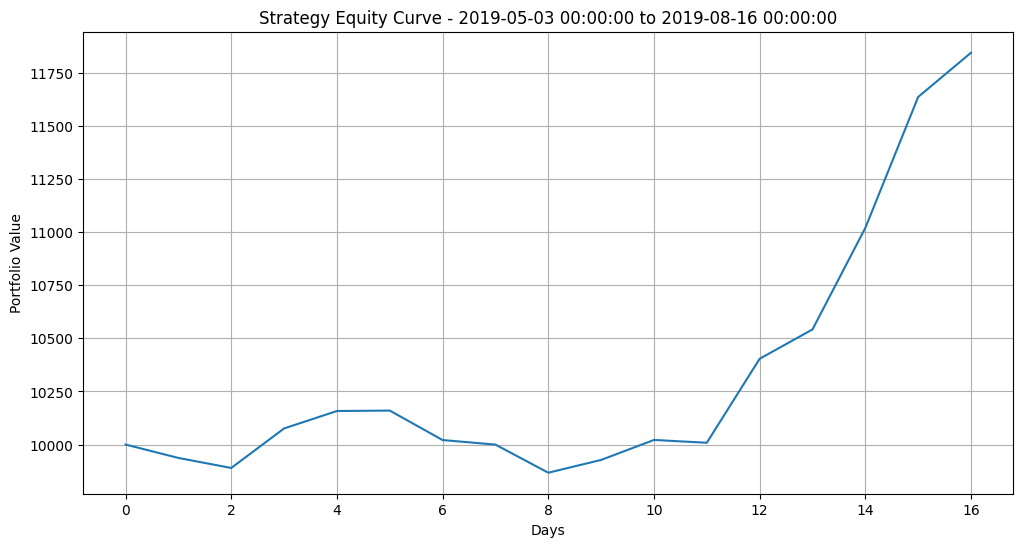


Period: 2019-09-04 00:00:00 to 2023-08-10 00:00:00
Base Model Metrics:
RMSE: 0.0150
R²: -0.8413

Trading Strategy Metrics:
Total Return: 4357.47%
Sharpe Ratio: 5.09
Max Drawdown: -23.16%
Win Rate: 71.28%


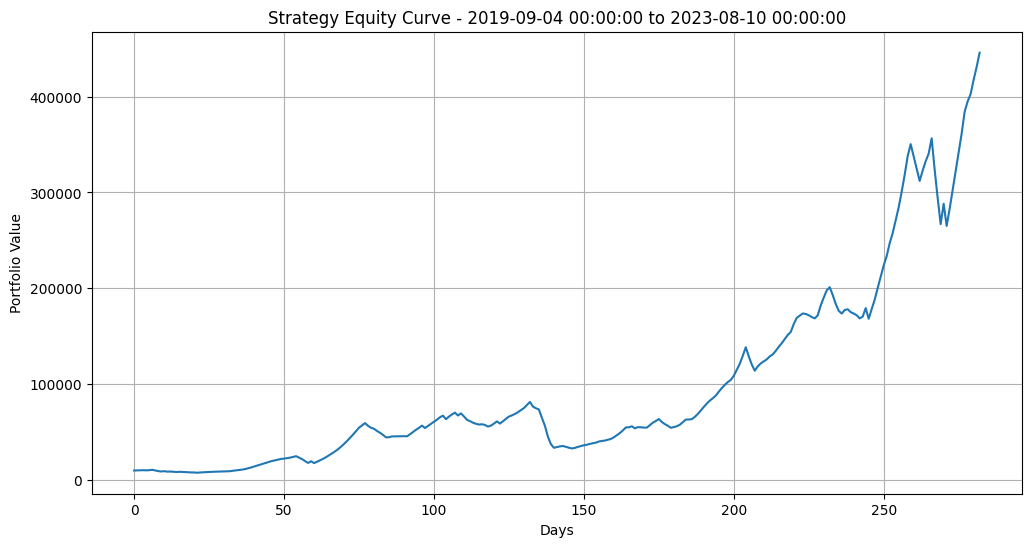


Period: 2024-03-07 00:00:00 to 2024-11-14 00:00:00
Base Model Metrics:
RMSE: 0.0120
R²: -1.4263

Trading Strategy Metrics:
Total Return: 69.32%
Sharpe Ratio: 4.99
Max Drawdown: 0.00%
Win Rate: 65.22%


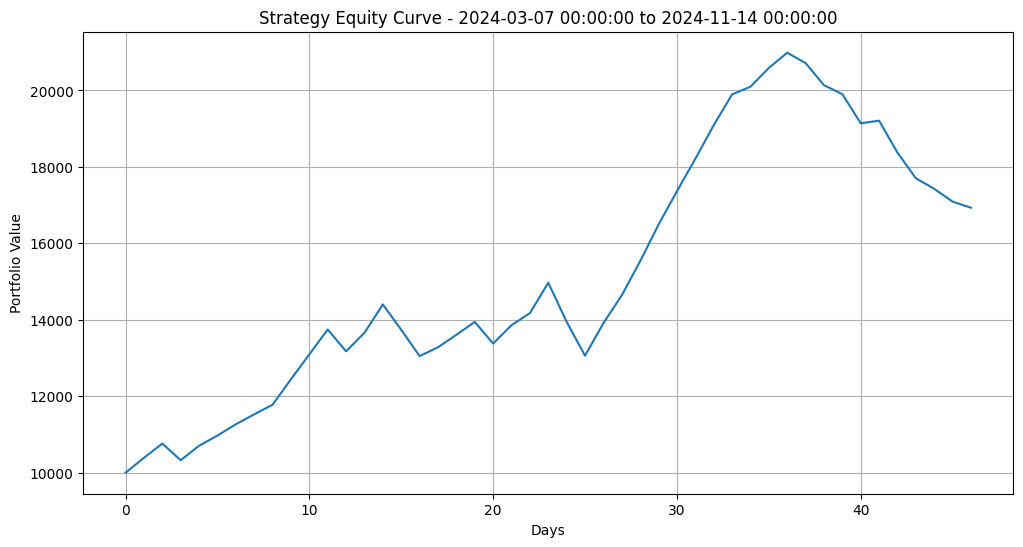

In [14]:
def train_evaluate_and_backtest_chunk(xgb_config, chunk_df, target_asset='Bitcoin', test_size=0.2,
                                    initial_capital=10000, position_size=0.1):
    """Extends your existing function to include straddle backtesting"""
    # Get everything from your original function
    results = train_and_evaluate_chunk(xgb_config, chunk_df, target_asset, test_size)
    if results is None:
        return None

    results, base_model, enhanced_model, test_df = results

    # Get the feature columns used for the base model (excluding sentiment)
    feature_cols = [col for col in test_df.columns
                   if not col.endswith('_ForwardVol') and
                   not any(x in col.lower() for x in ['sentiment', 'conviction'])]

    # Get predictions for test period
    base_pred = base_model.predict(test_df[feature_cols])

    # Calculate prediction z-score
    pred_zscore = pd.Series(base_pred, index=test_df.index).rolling(30, min_periods=1).apply(
        lambda x: (x.iloc[-1] - x.mean()) / x.std() if len(x) > 1 else 0
    )

    # Trading logic
    positions = pd.Series(0, index=test_df.index)
    threshold = 1.0
    positions.loc[pred_zscore > threshold] = 1    # Long straddle when predicted vol is high
    positions.loc[pred_zscore < threshold] = -1   # Short straddle when predicted vol is low

    # Initialize results tracking
    portfolio_value = initial_capital
    returns = []
    equity_curve = [initial_capital]

    # Simulation
    for i in range(1, len(positions)):
        pos = positions.iloc[i-1]

        if pos != 0:
            # Calculate return based on actual vs predicted volatility
            pred_vol = base_pred[i-1]
            actual_vol = test_df[f'{target_asset}_ForwardVol'].iloc[i]

            # Simulate straddle PnL
            if pos == 1:  # Long straddle
                trade_return = (actual_vol - pred_vol) / pred_vol
            else:  # Short straddle
                trade_return = (pred_vol - actual_vol) / pred_vol

            # Apply position sizing
            trade_size = portfolio_value * position_size
            trade_pnl = trade_size * trade_return

            portfolio_value += trade_pnl
            returns.append(trade_return)
        else:
            returns.append(0)

        equity_curve.append(portfolio_value)

    # Add trading metrics to results
    returns = pd.Series(returns)
    results.update({
        'strategy_return': (portfolio_value - initial_capital) / initial_capital,
        'sharpe_ratio': np.sqrt(252) * returns.mean() / returns.std() if len(returns) > 0 and returns.std() > 0 else 0,
        'max_drawdown': min(0, min(equity_curve) - initial_capital) / initial_capital,
        'equity_curve': equity_curve,
        'win_rate': len(returns[returns > 0]) / len(returns[returns != 0]) if len(returns[returns != 0]) > 0 else 0
    })

    return results, base_model, enhanced_model, test_df, equity_curve

# Run the analysis on all chunks
all_results = []
for chunk in chunks:
    full_results = train_evaluate_and_backtest_chunk(XGBConfig, chunk)
    if full_results is not None:
        results, base_model, enhanced_model, test_df, equity_curve = full_results
        all_results.append(results)

        print(f"\nPeriod: {results['period']}")
        print(f"Base Model Metrics:")
        print(f"RMSE: {results['base_rmse']:.4f}")
        print(f"R²: {results['base_r2']:.4f}")
        print(f"\nTrading Strategy Metrics:")
        print(f"Total Return: {results['strategy_return']:.2%}")
        print(f"Sharpe Ratio: {results['sharpe_ratio']:.2f}")
        print(f"Max Drawdown: {results['max_drawdown']:.2%}")
        print(f"Win Rate: {results['win_rate']:.2%}")

        # Plot equity curve for this chunk
        plt.figure(figsize=(12, 6))
        plt.plot(equity_curve)
        plt.title(f'Strategy Equity Curve - {results["period"]}')
        plt.xlabel('Days')
        plt.ylabel('Portfolio Value')
        plt.grid(True)
        plt.show()

In [15]:
XGBConfig

{'n_estimators': 417,
 'learning_rate': 0.09460742861521948,
 'max_depth': 9,
 'min_child_weight': 1,
 'subsample': 0.9556431030366573,
 'colsample_bytree': 0.5178785457560915,
 'random_state': 42}